<a href="https://colab.research.google.com/github/cwscx/makmore/blob/main/build_makemore_mlp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [137]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [138]:
# from google.colab import files
# uploaded = files.upload()

In [139]:
words: list[str] = open('names.txt', 'r').read().splitlines()

In [140]:
stoi: dict[str, int] = {c:i for i, c in enumerate('.abcdefghijklmnopqrstuvwxyz')}
itos: dict[int, str] = {i:c for c, i in stoi.items()}

In [141]:
block_size = 3

def build_dataset(words: list[str]) -> tuple[torch.Tensor, torch.Tensor]:
  inputs_list: list[list[int]] = []
  labels_list: list[int] = []

  for w in words:
    inputs: list[int] = [0] * block_size
    for c in w + '.':
      index: int = stoi[c]
      inputs_list.append(inputs)
      labels_list.append(index)
      inputs = inputs[1:] + [index]

  return torch.tensor(inputs_list), torch.tensor(labels_list)

import random
random.seed(42)
random.shuffle(words)
threshold1: int = int(0.8 * len(words))
threshold2: int = int(0.9 * len(words))

training_x, training_y = build_dataset(words[:threshold1])
validation_x, validation_y = build_dataset(words[threshold1:threshold2])
test_x, test_y = build_dataset(words[threshold2:])


In [219]:
g = torch.Generator().manual_seed(2147483647)

vocab_size = len(itos)
embedding = 10
hidden = 200

C = torch.randn((vocab_size, embedding), generator=g)
W1 = torch.randn((block_size * embedding, hidden), generator=g) * 0.2
b1 = torch.randn((hidden), generator=g) * 0.01
W2 = torch.randn((hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [220]:
max_steps = 200000
batch_size = 32
losses = []

for i in range(max_steps):
  batches = torch.randint(0, high=len(training_x), size=(batch_size,), generator=g)
  training_x_batch = training_x[batches]
  training_y_batch = training_y[batches]
  embedding = C[training_x_batch]
  h1 = embedding.view(embedding.shape[0], -1) @ W1 + b1
  # d tanh / dx = (1 - t**2) * out_grad.
  # t = (e^2x - 1) / (e^2x + 1)
  # if t = 1 or -1 or close, the grad will become almost 0.
  a1 = torch.tanh(h1)
  logits = h1 @ W2 + b2
  loss = F.cross_entropy(logits, training_y_batch)

  for p in parameters:
    p.grad = None

  loss.backward()

  lr = 0.1 if i < max_steps / 2 else 0.01
  for p in parameters:
    p.data -= lr * p.grad

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  losses.append(loss.log10().item())

  # break

      0/ 200000: 3.3281
  10000/ 200000: 2.2658
  20000/ 200000: 2.4549
  30000/ 200000: 2.5870
  40000/ 200000: 2.0670
  50000/ 200000: 2.6195
  60000/ 200000: 2.4372
  70000/ 200000: 2.2305
  80000/ 200000: 2.3998
  90000/ 200000: 2.1963
 100000/ 200000: 2.2078
 110000/ 200000: 2.3932
 120000/ 200000: 2.0874
 130000/ 200000: 2.4410
 140000/ 200000: 2.6016
 150000/ 200000: 2.4528
 160000/ 200000: 2.1866
 170000/ 200000: 2.0477
 180000/ 200000: 2.4291
 190000/ 200000: 2.1907


In [183]:
-torch.tensor(1/27.0).log() # expected negative log possibility

tensor(3.2958)

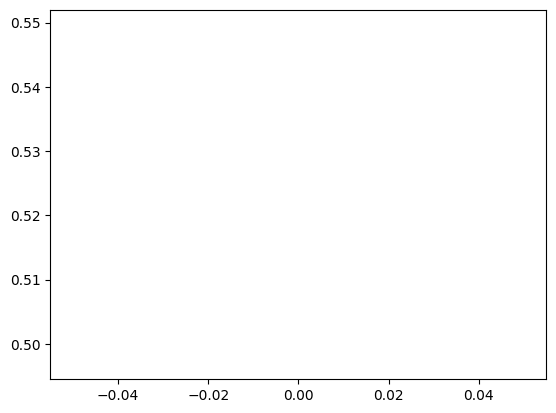

In [191]:
plt.plot(losses)

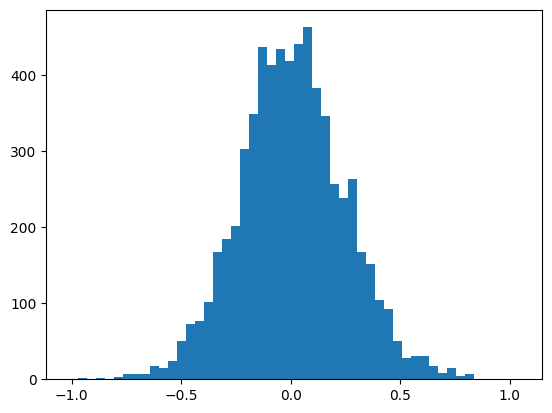

In [212]:
plt.hist(h1.view(-1).tolist(), 50);

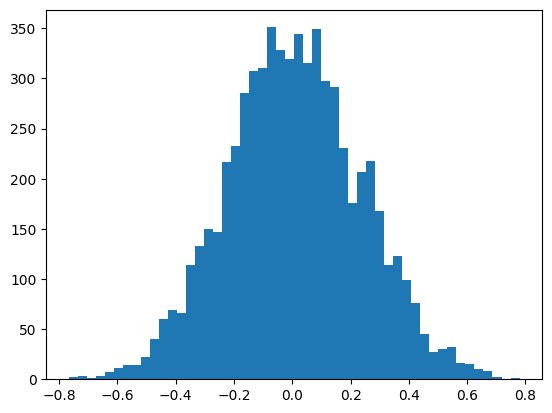

In [213]:
plt.hist(a1.view(-1).tolist(), 50);

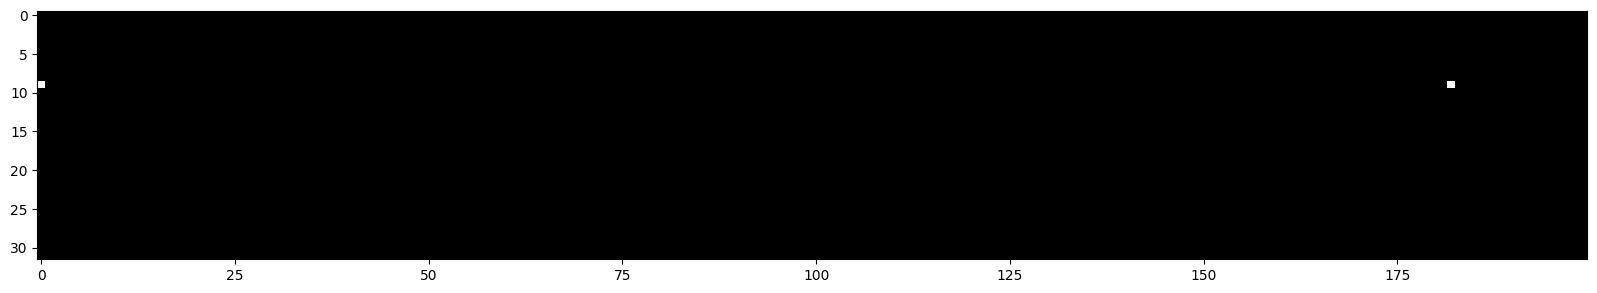

In [214]:
plt.figure(figsize=(20, 10))
# white is true. black is false.
plt.imshow(h1.abs() > 0.99, cmap="gray", interpolation="nearest")

In [221]:
@torch.no_grad() # disable gradient tracking to make method faster.
def split_loss(split):
  x, y = {
      'train': (training_x, training_y),
      'val': (validation_x, validation_y),
      'test': (test_x, test_y),
  }[split]
  emb = C[x]
  h = torch.tanh(emb.view(x.shape[0], -1) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('val')
split_loss('test')

val 2.308946371078491
test 2.3087363243103027


In [154]:
g = torch.Generator().manual_seed(2147483647 + 10)

for i in range(20):
  out = []
  inputs = [0] * block_size

  while True:
    h = torch.tanh(C[torch.tensor(inputs)].view(1,-1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    index = torch.multinomial(probs, num_samples=1, generator=g).item()
    inputs = inputs[1:] + [index]
    out.append(index)
    if (index == 0):
      break

  print(''.join(itos[i] for i in out))

carman.
amille.
khyrmyn.
reet.
khalayane.
mahnen.
deliah.
jareei.
nellara.
chaiivon.
legen.
ham.
jorn.
quintin.
lilea.
jadiquinterri.
jarysia.
kael.
dustine.
deciia.
